# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [9]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [10]:
str(date.today())

'2020-09-11'

In [11]:
st.get_links()

<Response [200]>


'wrote 164 links to data_acquisition/links-tsp-2020-09-11.txt'

In [12]:
scraped_file = 'data_acquisition/links-tsp-' + str(date.today()) + '.txt'
st.select_new_links(scraped_file)

Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the numer that was returned the last time the cell ran.

In [13]:
#%run 'data-acquisition/get-content-02.py'
#from data_acquisition import get_content_tsp_03

import os

path_to_link_file= 'data_acquisition/links-tsp-'+str(date.today())+'-new.txt'
path_to_output_folder='data_acquisition/tagesspiegel-'+str(date.today())

_, dirs, _ = next(os.walk(os.getcwd()))

if path_to_output_folder in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1382,path_to_output_folder)

1489

When articles are downloaded, add new links to 'bestand' (this file is needed to check for already downloaded articles, articles that are scraped on more than one occasion)

Note that the 'bestand's-file is hard coded.

In [16]:
!cat $path_to_link_file >> 'data_acquisition/links-tsp-bestand.txt'

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 5. remove content from plus.tagesspiegel.de (advertising, infotainment, Kundenbindung)
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [18]:
from data_cleaning import clean_tsp as ct

In [19]:
ct.clean_up('data_acquisition/tagesspiegel-2020-09-11','2020-09-11')

{'files inspected': 0,
 'files with ads': 33,
 'ads removed': 44,
 'files not clean': 9,
 'files bot clean reasons': ['content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)'],
 'dates imputed': 0}

In [22]:
# move clean files to where they will be picked up downstream in our workflow
!mv data_acquisition/tagesspiegel-2020-09-11/*clean.json articles_02

### protocols from previous cleanings

In [8]:
ct.clean_up('data_acquisition/tagesspiegel-2020-09-09','2020-09-09')

{'files inspected': 0,
 'files with ads': 63,
 'ads removed': 96,
 'files not clean': 8,
 'files bot clean reasons': ['too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)'],
 'dates imputed': 0}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [38]:
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

import re

from textblob_de import TextBlobDE 

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math

import json


def preprocess(text):
    #print(text)
    a = text.lower() # lower cases only
    b = re.sub("(\\W|\\d)"," ",a) #remove non-ascii and digits
    blob = TextBlobDE(b)
    return(blob.words.lemmatize()) # lemmatize for german


def read_articles_transform_to_df (path_to_text_files='articles_02/*clean.json', debug=False):

	file_list=glob.glob(path_to_text_files)
	#file_list = glob.glob("../tagesspiegel/*.txt")
	#print(file_list)

	n = len(file_list)
	print(n , "files to work with.")
	if debug==True:
		n_restrict = 50
		print('debug mode, working with a subset of ' + str(n_restrict) + ' files.')
		n = n_restrict
        
	#list_of_articles = []
	X = pd.DataFrame(columns=['file','file_name','title','text','description','date','image'])

	for i in range(n):
		if debug:
            print('*** '+str(i)+' ***' + file_list[i])
		with open (file_list[i]) as file:
			article = json.loads(file.read())
		X=X.append({'file':file_list[i] , 'file_name':article['text-link'], 'text':article['text'], 'title':article['title'], 'description':article['description'], 'date':article['publish-date'], 'image':article['image']}, ignore_index=True)
	return(X)

def enthropy(pv):
	# should check, that all values are positive and sum to (about) 1
	return(-sum([pv[i]*math.log(pv[i]) for i in range(len(pv))]))

def evaluate_cluster(km_object):
	n, bins, patches = plt.hist(km_object.labels_, km_object.n_clusters, facecolor='blue', alpha=0.5)
	plt.title('sizes of clusters')
	plt.ylabel('nr. of articles')
	plt.show()

	rel_fq = [round(ni/sum(n),3) for ni in n] 
#		print('elements in bins: ' , n)
#		print('relative size of bins: ', rel_fq)
#		print('enthropy: ', enthropy(rel_fq))

	return({'n': n , 'frequencies': rel_fq , 'enthropy': enthropy(rel_fq), 'inertia':km_object.inertia_})

preprocessing does some basic transfomation of a text into a wordlist:

Remove non ascii symbols and numbers / digits.

Remove punctuation. Lemmatize.

In [40]:
X = read_articles_transform_to_df('articles_02/*clean.json',debug=False)
#X['text'][0] # to check what we work with: Umlaute are correct, Data cleaning should have removed advertising text ...

98 files to work with.
*** 0 ***articles_02/01417-clean.json
*** 1 ***articles_02/01420-clean.json
*** 2 ***articles_02/01442-clean.json
*** 3 ***articles_02/01396-clean.json
*** 4 ***articles_02/01469-clean.json
*** 5 ***articles_02/01478-clean.json
*** 6 ***articles_02/01387-clean.json
*** 7 ***articles_02/01487-clean.json
*** 8 ***articles_02/01453-clean.json
*** 9 ***articles_02/01464-clean.json
*** 10 ***articles_02/01431-clean.json
*** 11 ***articles_02/01406-clean.json
*** 12 ***articles_02/01482-clean.json
*** 13 ***articles_02/01428-clean.json
*** 14 ***articles_02/01456-clean.json
*** 15 ***articles_02/01403-clean.json
*** 16 ***articles_02/01434-clean.json
*** 17 ***articles_02/01425-clean.json
*** 18 ***articles_02/01412-clean.json
*** 19 ***articles_02/01447-clean.json
*** 20 ***articles_02/01439-clean.json
*** 21 ***articles_02/01393-clean.json
*** 22 ***articles_02/01394-clean.json
*** 23 ***articles_02/01409-clean.json
*** 24 ***articles_02/01488-clean.json
*** 25 ***ar

In [41]:
# check result of read articles and transform to df:
X.head()

,file,file_name,title,text,description,date,image
0,articles_02/01417-clean.json,01417,Scheel rechnet mit baldiger Entscheidung über ...,Berlins Stadtentwicklungssenator Sebastian Sch...,Seit mehr als einem Jahr steht die Initiative ...,2020-09-11 09:16:28+02:00,https://www.tagesspiegel.de/images/deutsche-wo...
1,articles_02/01420-clean.json,01420,Retourkutsche zum Zwinger,"Barocke Feste, da denkt man zuerst natürlich a...",Deutsches Versailles: Dresden feiert die Fürst...,2019-06-25 09:14:36+02:00,https://www.tagesspiegel.de/images/heprodimage...
2,articles_02/01442-clean.json,01442,Bundeswehr verteilt Rosen am Brandenburger Tor,Die Bundeswehr wirbt zum Internationalen Fraue...,Die deutschen Streitkräfte wollen zum Weltfrau...,2019-03-07 08:09:30+01:00,https://www.tagesspiegel.de/images/fruehlingsw...
3,articles_02/01396-clean.json,01396,Laschet sucht Erfolg als „Merkel 2.0“,Die Kommunalwahlen in Nordrhein-Westfalen steh...,Die Stimmung wendet sich: Laschets Kurs in der...,2020-09-05 19:51:14+02:00,https://www.tagesspiegel.de/images/armin-lasch...
4,articles_02/01469-clean.json,01469,War's schlimm und eng? - Nö!,"Sein Vater ist früh gestorben, er ist früh ges...",Lehrer wollte er werden. Und kam in die DDR. D...,2020-09-11 10:34:35+02:00,https://www.tagesspiegel.de/images/maungue/261...


### compare : cluster titles (short, fast) or cluster text (long, slow)

Is it better to cluster by applying K-means to to titles or to the full text of the article? Since titles are short, clustering them is faster. But is the quality of clustering the full texts higher?

How do the resulting clusters differ?

In [42]:
list_of_titles = [' '.join(preprocess(t)) for t in X['title']]

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

text_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_titles[0:100])
text_cluster.fit(list_of_titles)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels

In [ ]:
# it could be good to cluster on the basis of title / headline and description.
# there are more words and it is easier to find overlaps.

# another approach would be to use word embeddings, either pretrained.
# Or: train the word embeddings on the articles' text and then use it only for the titles.

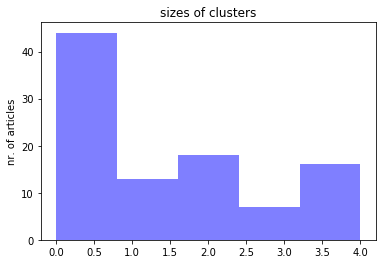

{'n': array([44., 13., 18.,  7., 16.]),
 'frequencies': [0.449, 0.133, 0.184, 0.071, 0.163],
 'enthropy': 1.4228058349308825,
 'inertia': 76.39021803726573}

In [43]:
evaluate_cluster(km)
#cv.get_feature_names()[0:10]

In [44]:
list_of_articles = [' '.join(preprocess(t)) for t in X['text']]

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

text_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_titles[0:100])
text_cluster.fit(list_of_articles)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels

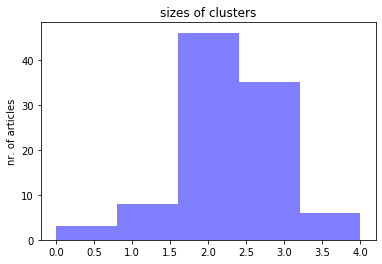

{'n': array([ 3.,  8., 46., 35.,  6.]),
 'frequencies': [0.031, 0.082, 0.469, 0.357, 0.061],
 'enthropy': 1.2062030191562205,
 'inertia': 82.89443279246368}

In [45]:
evaluate_cluster(km)


### how stuff works

In [5]:
# how preprocessing works
preprocess('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')

WordList(['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen'])

In [69]:
# the list of titles
[' '.join(preprocess(t)) for t in X['title']]

['scheel rechnet mit baldig entscheidung über berlin volksbegehren',
 'retourkutschen zum zwinger',
 'Bundeswehr verteilen rosen am brandenburger tor',
 'laschet suchen erfolg als merkel',
 'sein s schlimm und eng nö',
 'wie wir über den erst corona winter kommen entscheidet sich jetzt',
 'der run der wall street auf das vermögen der neu mittelschicht',
 'wieder grossfeuer im hafengebiet von beirut',
 'der aufklärer assange als unperson',
 'lothar corona der fc',
 'horst seehofer der buhmann',
 'bei ein mann werden man sagen wow haben der mumm',
 'die chefin mit neu kollegen',
 'an dies schulen werden neu corona fälle bekannt',
 'die stadt ist wild als du denkst und freundlich als du glaubst',
 'die chinesisch international dienstleistungsmesse wurde erfolgreich abgeschlossen',
 'Warnstreiks bei der post in berlin',
 'trump vergleichen sich mit churchill',
 'patricia schlesinger vor wiederwahl',
 'michael rother für mich sein das kein nostalgi trip']

## Word cloud representation for cluster

Collect all text from a specified cluster and create its wordcloud.

Some stopwords are features.

In [52]:
my_stopper = ['ist','nur','sein','seine','deine','meine','am','sie','bei','durch','noch','sich','in','im','ihr','ihre','vor','zur','seit','es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']
'ist' in my_stopper
# [w in cv.get_feature_names() for w in my_stopper]

True

For each cluster save the articles belonging to the cluster in a csv file.

For each cluster create a wordcloud from all article titles to represent the cluster.


In [53]:
#!pip install wordcloud
from wordcloud import WordCloud

K=km.n_clusters
for k in range(K):
    Xcl = X.loc[X['cluster']==k]
    
    # write articles in this cluster to csv file
    ## needed later to display headlines and text from the (externally running) Flask server
    
    filename = 'html_pres/static/articles_cluster'+str(k)+'.csv'
    Xcl.to_csv(filename, sep=';', encoding='utf-8', header=True)
    
    # all words of all titles in one string, preprocessed and without stopp words
    t1 = [' '.join(preprocess(t)) for t in Xcl['title']]
    t2 = ' '.join(t1)
    text = [w for w in t2.split() if w not in my_stopper]
    
    wordcloud = WordCloud().generate(' '.join(text))
    wordcloud.to_file('html_pres/static/image_cluster'+str(k)+'.png')

## presentation as html , website

* call an external python script to start the server (Flask)
* go to 127.0.0.0:5005 to interact with the website

In [31]:
#!pip install pyttsx3
import pyttsx3
engine = pyttsx3.init()
# available voices / languages
#for v in engine.getProperty('voices'): 
#    print(v.languages, v.id, v.name)

In [32]:
# transform text to speach and save to an mp3 file 
text=X.iloc[0]['text'][0:300]
print(text)
engine.setProperty('rate', 140)
engine.setProperty('voice', 'com.apple.speech.synthesis.voice.anna')
# print(engine.getProperty('voice'))
engine.say(text)
engine.save_to_file(text, 'read_description.mp3')
engine.runAndWait()
engine.stop()

Berlins Stadtentwicklungssenator Sebastian Scheel (Linke) strebt an, dass der Senat bis zum 22. September über die Zulässigkeit des geplanten Volksbegehrens zur Enteignung großer Wohnungsunternehmen entscheidet.

In Erwartung eines positiven Prüfbescheids der Innenverwaltung, der noch nicht vorliege
com.apple.speech.synthesis.voice.Alex


'Berlins Stadtentwicklungssenator Sebastian Scheel (Linke) strebt an, dass der Senat bis zum 22. September über die Zulässigkeit des geplanten Volksbegehrens zur Enteignung großer Wohnungsunternehmen entscheidet.\n\nIn Erwartung eines positiven Prüfbescheids der Innenverwaltung, der noch nicht vorliege'

In [55]:
!python html_pres/app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
127.0.0.1 - - [11/Sep/2020 22:47:48] "GET / HTTP/1.1" 200 -
*******************
static/articles_cluster3.csv
*******************
127.0.0.1 - - [11/Sep/2020 22:47:50] "GET /readmore/3 HTTP/1.1" 500 -
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2328, in __call__
    return self.wsgi_app(environ, start_response)
  File "/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2314, in wsgi_app
    response = self.handle_exception(e)
  File "/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1760, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "/anaconda3/lib/python3.7/site-packages/flask/_compat.py", line 36, in reraise
    raise value
  File "/a

127.0.0.1 - - [11/Sep/2020 22:50:01] "GET /readmore/0?__debugger__=yes&cmd=resource&f=style.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:50:01] "GET /readmore/0?__debugger__=yes&cmd=resource&f=debugger.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:50:01] "GET /readmore/0?__debugger__=yes&cmd=resource&f=jquery.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:50:01] "GET /readmore/0?__debugger__=yes&cmd=resource&f=console.png HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:50:01] "GET /readmore/0?__debugger__=yes&cmd=resource&f=ubuntu.ttf HTTP/1.1" 200 -
 * Detected change in '/Users/silke/Documents/studiumDataScience/semester2/DSW/newsreader/html_pres/app.py', reloading
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
 * Detected change in '/Users/silke/Documents/studiumDataScience/semester2/DSW/newsreader/html_pres/app.py', reloading
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
*******************
static/articles_cluster2.

127.0.0.1 - - [11/Sep/2020 22:52:54] "GET /readmore/0?__debugger__=yes&cmd=resource&f=style.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:52:54] "GET /readmore/0?__debugger__=yes&cmd=resource&f=jquery.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:52:54] "GET /readmore/0?__debugger__=yes&cmd=resource&f=debugger.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:52:54] "GET /readmore/0?__debugger__=yes&cmd=resource&f=ubuntu.ttf HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 22:52:54] "GET /readmore/0?__debugger__=yes&cmd=resource&f=console.png HTTP/1.1" 200 -
 * Detected change in '/Users/silke/Documents/studiumDataScience/semester2/DSW/newsreader/html_pres/app.py', reloading
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
*******************
./static/articles_cluster2.csv
/Users/silke/Documents/studiumDataScience/semester2/DSW/newsreader
*******************
127.0.0.1 - - [11/Sep/2020 22:54:28] "GET /readmore/2 HTTP/1.1" 500 -
Traceback (most recent call last

 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
127.0.0.1 - - [11/Sep/2020 23:03:53] "GET /article/1414 HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 23:03:53] "GET /static/01414.mp3 HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 23:04:17] "GET /article/1417 HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 23:04:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
127.0.0.1 - - [11/Sep/2020 23:04:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
127.0.0.1 - - [11/Sep/2020 23:04:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
127.0.0.1 - - [11/Sep/2020 23:05:12] "GET /article/1417 HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 23:05:18] "GET /article/1417 HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2020 23:05:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
127.0.0.1 - - [11/Sep/2020 23:05:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
127.0.0.1 - - [11/Sep/2020 23:05:19] "GET /static/01417.mp3 HTTP/1.1" 206 -
 * Detected change in '/Users/silke/Documents/studiumDataScience/semester2/DSW/newsreader/html_pres/app.